# Modern NLP in Python
### _- Or -_
## What you can learn about food by analyzing a million Yelp reviews

#### Before we get started...
__whois?__
- Patrick Harrison
- Lead Data Scientist @ S&P Global Market Intelligence - _**we are hiring**_
- University of Virginia &mdash; Systems Engineering
- patrick@skipgram.io / @skipgram

__Join Charlottesville Data Science!__
- On Meetup.com ... http://www.meetup.com/CharlottesvilleDataScience
- On Slack ... __https://cville.typeform.com/to/UEzMVh__
  - _link invites you to join the Cville team on Slack. Join Cville, then join channel __#datascience__._
  
_Note: I presented this notebook as a tutorial during the [PyData DC 2016 conference](http://pydata.org/dc2016/schedule/presentation/11/). To view the video of the presentation on YouTube, see [here](https://www.youtube.com/watch?v=6zm9NC9uRkk)._

## Our Trail Map
This tutorial features an end-to-end data science & natural language processing pipeline, starting with **raw data** and running through **preparing**, **modeling**, **visualizing**, and **analyzing** the data. We'll touch on the following points:
1. A tour of the dataset
1. Introduction to text processing with spaCy
1. Automatic phrase modeling
1. Topic modeling with LDA
1. Visualizing topic models with pyLDAvis
1. Word vector models with word2vec
1. Visualizing word2vec with t-SNE

...and we might even learn a thing or two about Python along the way.

Let's get started!

## The Yelp Dataset
[**The Yelp Dataset**](https://www.yelp.com/dataset_challenge/) is a dataset published by the business review service [Yelp](http://yelp.com) for academic research and educational purposes. I really like the Yelp dataset as a subject for machine learning and natural language processing demos, because it's big (but not so big that you need your own data center to process it), well-connected, and anyone can relate to it &mdash; it's largely about food, after all!

**Note:** If you'd like to execute this notebook interactively on your local machine, you'll need to download your own copy of the Yelp dataset. If you're reviewing a static copy of the notebook online, you can skip this step. Here's how to get the dataset:
1. Please visit the Yelp dataset webpage [here](https://www.yelp.com/dataset_challenge/)
1. Click "Get the Data"
1. Please review, agree to, and respect Yelp's terms of use!
1. The dataset downloads as a compressed .tgz file; uncompress it
1. Place the uncompressed dataset files (*yelp_academic_dataset_business.json*, etc.) in a directory named *yelp_dataset_challenge_academic_dataset*
1. Place the *yelp_dataset_challenge_academic_dataset* within the *data* directory in the *Modern NLP in Python* project folder

That's it! You're ready to go.

The current iteration of the Yelp dataset (as of this demo) consists of the following data:
- __552K__ users
- __77K__ businesses
- __2.2M__ user reviews

When focusing on restaurants alone, there are approximately __22K__ restaurants with approximately __1M__ user reviews written about them.

The data is provided in a handful of files in _.json_ format. We'll be using the following files for our demo:
- __yelp\_academic\_dataset\_business.json__ &mdash; _the records for individual businesses_
- __yelp\_academic\_dataset\_review.json__ &mdash; _the records for reviews users wrote about businesses_

The files are text files (UTF-8) with one _json object_ per line, each one corresponding to an individual data record. Let's take a look at a few examples.

In [16]:
import os
import codecs

data_directory = os.path.join('..', 'data')

businesses_filepath = os.path.join(data_directory,
                                   'business.json')

with codecs.open(businesses_filepath, encoding='utf_8') as f:
    first_business_record = f.readline() 

print(first_business_record)

{"business_id": "YDf95gJZaq05wvo7hTQbbQ", "name": "Richmond Town Square", "neighborhood": "", "address": "691 Richmond Rd", "city": "Richmond Heights", "state": "OH", "postal_code": "44143", "latitude": 41.5417162, "longitude": -81.4931165, "stars": 2.0, "review_count": 17, "is_open": 1, "attributes": {"RestaurantsPriceRange2": 2, "BusinessParking": {"garage": false, "street": false, "validated": false, "lot": true, "valet": false}, "BikeParking": true, "WheelchairAccessible": true}, "categories": ["Shopping", "Shopping Centers"], "hours": {"Monday": "10:00-21:00", "Tuesday": "10:00-21:00", "Friday": "10:00-21:00", "Wednesday": "10:00-21:00", "Thursday": "10:00-21:00", "Sunday": "11:00-18:00", "Saturday": "10:00-21:00"}}



In [17]:
type(first_business_record)

str

The business records consist of _key, value_ pairs containing information about the particular business. A few attributes we'll be interested in for this demo include:
- __business\_id__ &mdash; _unique identifier for businesses_
- __categories__ &mdash; _an array containing relevant category values of businesses_

The _categories_ attribute is of special interest. This demo will focus on restaurants, which are indicated by the presence of the _Restaurant_ tag in the _categories_ array. In addition, the _categories_ array may contain more detailed information about restaurants, such as the type of food they serve.

The review records are stored in a similar manner &mdash; _key, value_ pairs containing information about the reviews.

In [18]:
review_json_filepath = os.path.join(data_directory,
                                    'review.json')

with codecs.open(review_json_filepath, encoding='utf_8') as f:
    first_review_record = f.readline()
    
print(first_review_record)

{"review_id":"VfBHSwC5Vz_pbFluy07i9Q","user_id":"cjpdDjZyprfyDG3RlkVG3w","business_id":"uYHaNptLzDLoV_JZ_MuzUA","stars":5,"date":"2016-07-12","text":"My girlfriend and I stayed here for 3 nights and loved it. The location of this hotel and very decent price makes this an amazing deal. When you walk out the front door Scott Monument and Princes street are right in front of you, Edinburgh Castle and the Royal Mile is a 2 minute walk via a close right around the corner, and there are so many hidden gems nearby including Calton Hill and the newly opened Arches that made this location incredible.\n\nThe hotel itself was also very nice with a reasonably priced bar, very considerate staff, and small but comfortable rooms with excellent bathrooms and showers. Only two minor complaints are no telephones in room for room service (not a huge deal for us) and no AC in the room, but they have huge windows which can be fully opened. The staff were incredible though, letting us borrow umbrellas for t

A few attributes of note on the review records:
- __business\_id__ &mdash; _indicates which business the review is about_
- __text__ &mdash; _the natural language text the user wrote_

The _text_ attribute will be our focus today!

_json_ is a handy file format for data interchange, but it's typically not the most usable for any sort of modeling work. Let's do a bit more data preparation to get our data in a more usable format. Our next code block will do the following:
1. Read in each business record and convert it to a Python `dict`
2. Filter out business records that aren't about restaurants (i.e., not in the "Restaurant" category)
3. Create a `frozenset` of the business IDs for restaurants, which we'll use in the next step

In [20]:
import json

restaurant_ids = set()

# open the businesses file
with codecs.open(businesses_filepath, encoding='utf_8') as f:
    
    # iterate through each line (json record) in the file
    for business_json in f:
        
        # convert the json record to a Python dict
        business = json.loads(business_json)
        
        # if this business is not a restaurant, skip to the next one
        if u'Restaurants' not in business[u'categories']:
            continue
        #if u'pizza' not in business[u'state']:
            #continue
            
        # add the restaurant business id to our restaurant_ids set
        restaurant_ids.add(business[u'business_id'])

# turn restaurant_ids into a frozenset, as we don't need to change it anymore
restaurant_ids = frozenset(restaurant_ids)

# print the number of unique restaurant ids in the dataset
print('{:,}'.format(len(restaurant_ids)), u'restaurants in the dataset.')

51,613 restaurants in the dataset.


In [21]:
business

{'address': '540 Marks St',
 'attributes': {'BikeParking': True,
  'BusinessAcceptsCreditCards': True,
  'BusinessParking': {'garage': False,
   'lot': True,
   'street': False,
   'valet': False,
   'validated': False},
  'RestaurantsPriceRange2': 1,
  'WheelchairAccessible': True},
 'business_id': 'scMIE4jyGp7FkWrMKAgjxA',
 'categories': ['Fashion',
  'Shopping',
  'Food',
  'Department Stores',
  'Mobile Phones',
  'Grocery'],
 'city': 'Henderson',
 'hours': {},
 'is_open': 0,
 'latitude': 36.0607079,
 'longitude': -115.0332406,
 'name': 'Walmart',
 'neighborhood': '',
 'postal_code': '89014',
 'review_count': 42,
 'stars': 2.5,
 'state': 'NV'}

In [22]:
len(business)

15

Next, we will create a new file that contains only the text from reviews about restaurants, with one review per line in the file.

In [23]:
intermediate_directory = os.path.join('..', 'intermediate')

review_txt_filepath = os.path.join(intermediate_directory,
                                   'review_text_all.txt')

In [24]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to execute data prep yourself.
if 0 == 1:
    
    review_count = 0

    # create & open a new file in write mode
    with codecs.open(review_txt_filepath, 'wb', encoding='utf_8') as review_txt_file:

        # open the existing review json file
        with codecs.open(review_json_filepath, encoding='utf_8') as review_json_file:

            # loop through all reviews in the existing file and convert to dict
            for review_json in review_json_file:
                review = json.loads(review_json)

                # if this review is not about a restaurant, skip to the next one
                if review[u'business_id'] not in restaurant_ids:
                    continue
                
                if 'pizza' not in review[u'text']:
                    continue

                # write the restaurant review as a line in the new file
                # escape newline characters in the original review text
                review_txt_file.write(review[u'text'].replace('\n', '\\n') + '\n')
                review_count += 1

    print(u'''Text from {:,} restaurant reviews
              written to the new txt file.'''.format(review_count))
    
else:
    
    with codecs.open(review_txt_filepath, encoding='utf_8') as review_txt_file:
        for review_count, line in enumerate(review_txt_file):
            pass
        
    print(u'Text from {:,} restaurant reviews in the txt file.'.format(review_count + 1))

Text from 193,145 restaurant reviews in the txt file.
CPU times: user 4 s, sys: 38.7 ms, total: 4.04 s
Wall time: 4.06 s


## spaCy &mdash; Industrial-Strength NLP in Python

![spaCy](https://s3.amazonaws.com/skipgram-images/spaCy.png)

[**spaCy**](https://spacy.io) is an industrial-strength natural language processing (_NLP_) library for Python. spaCy's goal is to take recent advancements in natural language processing out of research papers and put them in the hands of users to build production software.

spaCy handles many tasks commonly associated with building an end-to-end natural language processing pipeline:
- Tokenization
- Text normalization, such as lowercasing, stemming/lemmatization
- Part-of-speech tagging
- Syntactic dependency parsing
- Sentence boundary detection
- Named entity recognition and annotation

In the "batteries included" Python tradition, spaCy contains built-in data and models which you can use out-of-the-box for processing general-purpose English language text:
- Large English vocabulary, including stopword lists
- Token "probabilities"
- Word vectors

spaCy is written in optimized Cython, which means it's _fast_. According to a few independent sources, it's the fastest syntactic parser available in any language. Key pieces of the spaCy parsing pipeline are written in pure C, enabling efficient multithreading (i.e., spaCy can release the _GIL_).

In [25]:
import spacy
import pandas as pd
import itertools as it

nlp = spacy.load('en')

Let's grab a sample review to play with.

In [26]:
with codecs.open(review_txt_filepath, encoding='utf_8') as f:
    sample_review = list(it.islice(f, 8, 9))[0]
    sample_review = sample_review.replace('\\n', '\n')
        
print(sample_review)

So here's the thing. This isn't an Indian restaurant. No matter how you spin it. 

The "naan" is actually pita. The kind you buy in stores. There are three or four Indian curries on the menu. 
We got the chicken curry. The guy (there was only one person there, to cook and work the counter, but they weren't busy, so hey) said it was really good. If you're desi, you know what shan and all the boxed masalas taste like, and this definitely had that taste. 

Not saying it's a bad thing, but fresh masalas give a curry an aroma that this lacked. 

The chicken shish kabob was bland, except for the red chili powder added liberally on top, and it wasn't actual shish kabob. 

The best thing I had was the lamb burger. Oh my gosh. The lamb was super juicy. And the fries already had black pepper. Loved it. 

The place is super duper clean. Even the bathroom. 

Like I said, there was one person to cook, serve, answer calls, and take orders. He told us the others were out for a catering. 

This is in 

Hand the review text to spaCy, and be prepared to wait...

In [27]:
%%time
parsed_review = nlp(sample_review)

CPU times: user 124 ms, sys: 18.4 ms, total: 142 ms
Wall time: 101 ms


...1/20th of a second or so. Let's take a look at what we got during that time...

In [28]:
print(parsed_review)

So here's the thing. This isn't an Indian restaurant. No matter how you spin it. 

The "naan" is actually pita. The kind you buy in stores. There are three or four Indian curries on the menu. 
We got the chicken curry. The guy (there was only one person there, to cook and work the counter, but they weren't busy, so hey) said it was really good. If you're desi, you know what shan and all the boxed masalas taste like, and this definitely had that taste. 

Not saying it's a bad thing, but fresh masalas give a curry an aroma that this lacked. 

The chicken shish kabob was bland, except for the red chili powder added liberally on top, and it wasn't actual shish kabob. 

The best thing I had was the lamb burger. Oh my gosh. The lamb was super juicy. And the fries already had black pepper. Loved it. 

The place is super duper clean. Even the bathroom. 

Like I said, there was one person to cook, serve, answer calls, and take orders. He told us the others were out for a catering. 

This is in 

Looks the same! What happened under the hood?

What about sentence detection and segmentation?

In [29]:
for num, sentence in enumerate(parsed_review.sents):
    print('Sentence {}:'.format(num + 1))
    print(sentence)
    print('')

Sentence 1:
So here's the thing.

Sentence 2:
This isn't an Indian restaurant.

Sentence 3:
No matter how you spin it. 



Sentence 4:
The "naan" is actually pita.

Sentence 5:
The kind you buy in stores.

Sentence 6:
There are three or four Indian curries on the menu. 


Sentence 7:
We got the chicken curry.

Sentence 8:
The guy (there was only one person there, to cook and work the counter, but they weren't busy, so

Sentence 9:
hey) said it was really good.

Sentence 10:
If you're desi, you know what shan and all the boxed masalas taste like, and this definitely had that taste. 



Sentence 11:
Not saying it's a bad thing, but fresh masalas give a curry an aroma that this lacked. 



Sentence 12:
The chicken shish kabob was bland, except for the red chili powder added liberally on top, and it wasn't actual shish kabob. 



Sentence 13:
The best thing I had was the lamb burger.

Sentence 14:
Oh my gosh.

Sentence 15:
The lamb was super juicy.

Sentence 16:
And the fries already had b

What about named entity detection?

In [30]:
for num, entity in enumerate(parsed_review.ents):
    print('Entity {}:'.format(num + 1), entity, '-', entity.label_)
    print('')

Entity 1: Indian - NORP

Entity 2: three - CARDINAL

Entity 3: four - CARDINAL

Entity 4: Indian - NORP

Entity 5: 
 - GPE

Entity 6: Loved - NORP

Entity 7: one - CARDINAL

Entity 8: Indian - NORP

Entity 9: Indian - NORP

Entity 10: Middle Eastern - LOC

Entity 11: Indian - NORP

Entity 12: 
 - GPE



In [31]:
for token in parsed_review:
    print(token.pos_)

ADV
ADV
VERB
DET
NOUN
PUNCT
DET
VERB
ADV
DET
ADJ
NOUN
PUNCT
ADV
ADV
ADV
PRON
VERB
PRON
PUNCT
SPACE
DET
PUNCT
NOUN
PUNCT
VERB
ADV
NOUN
PUNCT
DET
NOUN
PRON
VERB
ADP
NOUN
PUNCT
ADV
VERB
NUM
CCONJ
NUM
ADJ
NOUN
ADP
DET
NOUN
PUNCT
SPACE
PRON
VERB
DET
NOUN
NOUN
PUNCT
DET
NOUN
PUNCT
ADV
VERB
ADV
NUM
NOUN
ADV
PUNCT
PART
VERB
CCONJ
VERB
DET
NOUN
PUNCT
CCONJ
PRON
VERB
ADV
ADJ
PUNCT
ADV
INTJ
PUNCT
VERB
PRON
VERB
ADV
ADJ
PUNCT
ADP
PRON
VERB
ADJ
PUNCT
PRON
VERB
NOUN
NOUN
CCONJ
ADJ
DET
VERB
NOUN
VERB
ADP
PUNCT
CCONJ
DET
ADV
VERB
DET
NOUN
PUNCT
SPACE
ADV
VERB
PRON
VERB
DET
ADJ
NOUN
PUNCT
CCONJ
ADJ
NOUN
VERB
DET
NOUN
DET
NOUN
ADP
DET
VERB
PUNCT
SPACE
DET
NOUN
NOUN
NOUN
VERB
ADJ
PUNCT
ADP
ADP
DET
ADJ
NOUN
NOUN
VERB
ADV
ADP
NOUN
PUNCT
CCONJ
PRON
VERB
ADV
ADJ
ADJ
NOUN
PUNCT
SPACE
DET
ADJ
NOUN
PRON
VERB
VERB
DET
NOUN
NOUN
PUNCT
INTJ
INTJ
INTJ
PUNCT
DET
NOUN
VERB
ADV
ADJ
PUNCT
CCONJ
DET
NOUN
ADV
VERB
ADJ
NOUN
PUNCT
VERB
PRON
PUNCT
SPACE
DET
NOUN
VERB
ADV
NOUN
NOUN
PUNCT
ADV
DET
NOUN
PUNCT
SPACE
INTJ
PRON
VE

What about part of speech tagging?

In [32]:
token_text = [token.orth_ for token in parsed_review]
token_pos = [token.pos_ for token in parsed_review]


pd.DataFrame(list(zip(token_text, token_pos)),
             columns=['token_text', 'part_of_speech'])

,token_text,part_of_speech
0,So,ADV
1,here,ADV
2,'s,VERB
3,the,DET
4,thing,NOUN
5,.,PUNCT
6,This,DET
7,is,VERB
8,n't,ADV
9,an,DET


What about text normalization, like stemming/lemmatization and shape analysis?

In [33]:
token_lemma = [token.lemma_ for token in parsed_review]
token_shape = [token.shape_ for token in parsed_review]

pd.DataFrame(list(zip(token_text, token_lemma, token_shape)),
             columns=['token_text', 'token_lemma', 'token_shape'])

,token_text,token_lemma,token_shape
0,So,so,Xx
1,here,here,xxxx
2,'s,have,'x
3,the,the,xxx
4,thing,thing,xxxx
5,.,.,.
6,This,this,Xxxx
7,is,be,xx
8,n't,not,x'x
9,an,a,xx


What about token-level entity analysis?

In [34]:
token_entity_type = [token.ent_type_ for token in parsed_review]
token_entity_iob = [token.ent_iob_ for token in parsed_review]

pd.DataFrame(list(zip(token_text, token_entity_type, token_entity_iob)),
             columns=['token_text', 'entity_type', 'inside_outside_begin'])

,token_text,entity_type,inside_outside_begin
0,So,,O
1,here,,O
2,'s,,O
3,the,,O
4,thing,,O
5,.,,O
6,This,,O
7,is,,O
8,n't,,O
9,an,,O


What about a variety of other token-level attributes, such as the relative frequency of tokens, and whether or not a token matches any of these categories?
- stopword
- punctuation
- whitespace
- represents a number
- whether or not the token is included in spaCy's default vocabulary?

In [35]:
token_attributes = [(token.orth_,
                     token.prob,
                     token.is_stop,
                     token.is_punct,
                     token.is_space,
                     token.like_num,
                     token.is_oov)
                    for token in parsed_review]

df = pd.DataFrame(token_attributes,
                  columns=['text',
                           'log_probability',
                           'stop?',
                           'punctuation?',
                           'whitespace?',
                           'number?',
                           'out of vocab.?'])

df.loc[:, 'stop?':'out of vocab.?'] = (df.loc[:, 'stop?':'out of vocab.?']
                                       .applymap(lambda x: u'Yes' if x else u''))
                                               
df

,text,log_probability,stop?,punctuation?,whitespace?,number?,out of vocab.?
0,So,-20.0,,,,,Yes
1,here,-20.0,Yes,,,,Yes
2,'s,-20.0,,,,,Yes
3,the,-20.0,Yes,,,,Yes
4,thing,-20.0,,,,,Yes
5,.,-20.0,,Yes,,,Yes
6,This,-20.0,,,,,Yes
7,is,-20.0,Yes,,,,Yes
8,n't,-20.0,,,,,Yes
9,an,-20.0,Yes,,,,Yes


If the text you'd like to process is general-purpose English language text (i.e., not domain-specific, like medical literature), spaCy is ready to use out-of-the-box.

I think it will eventually become a core part of the Python data science ecosystem &mdash; it will do for natural language computing what other great libraries have done for numerical computing.

## Phrase Modeling

_Phrase modeling_ is another approach to learning combinations of tokens that together represent meaningful multi-word concepts. We can develop phrase models by looping over the the words in our reviews and looking for words that _co-occur_ (i.e., appear one after another) together much more frequently than you would expect them to by random chance. The formula our phrase models will use to determine whether two tokens $A$ and $B$ constitute a phrase is:

$$\frac{count(A\ B) - count_{min}}{count(A) * count(B)} * N > threshold$$

...where:
* $count(A)$ is the number of times token $A$ appears in the corpus
* $count(B)$ is the number of times token $B$ appears in the corpus
* $count(A\ B)$ is the number of times the tokens $A\ B$ appear in the corpus *in order*
* $N$ is the total size of the corpus vocabulary
* $count_{min}$ is a user-defined parameter to ensure that accepted phrases occur a minimum number of times
* $threshold$ is a user-defined parameter to control how strong of a relationship between two tokens the model requires before accepting them as a phrase

Once our phrase model has been trained on our corpus, we can apply it to new text. When our model encounters two tokens in new text that identifies as a phrase, it will merge the two into a single new token.

Phrase modeling is superficially similar to named entity detection in that you would expect named entities to become phrases in the model (so _new york_ would become *new\_york*). But you would also expect multi-word expressions that represent common concepts, but aren't specifically named entities (such as _happy hour_) to also become phrases in the model.

We turn to the indispensible [**gensim**](https://radimrehurek.com/gensim/index.html) library to help us with phrase modeling &mdash; the [**Phrases**](https://radimrehurek.com/gensim/models/phrases.html) class in particular.

In [36]:
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence

As we're performing phrase modeling, we'll be doing some iterative data transformation at the same time. Our roadmap for data preparation includes:

1. Segment text of complete reviews into sentences & normalize text
1. First-order phrase modeling $\rightarrow$ _apply first-order phrase model to transform sentences_
1. Second-order phrase modeling $\rightarrow$ _apply second-order phrase model to transform sentences_
1. Apply text normalization and second-order phrase model to text of complete reviews

We'll use this transformed data as the input for some higher-level modeling approaches in the following sections.

First, let's define a few helper functions that we'll use for text normalization. In particular, the `lemmatized_sentence_corpus` generator function will use spaCy to:
- Iterate over the 1M reviews in the `review_txt_all.txt` we created before
- Segment the reviews into individual sentences
- Remove punctuation and excess whitespace
- Lemmatize the text

... and do so efficiently in parallel, thanks to spaCy's `nlp.pipe()` function.

In [37]:
def punct_space(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """
    
    return token.is_punct or token.is_space

def line_review(filename):
    """
    generator function to read in reviews from the file
    and un-escape the original line breaks in the text
    """
    
    with codecs.open(filename, encoding='utf_8') as f:
        for review in f:
            yield review.replace('\\n', '\n')
            
def lemmatized_sentence_corpus(filename):
    """
    generator function to use spaCy to parse reviews,
    lemmatize the text, and yield sentences
    """
    
    for parsed_review in nlp.pipe(line_review(filename),
                                  batch_size=10000, n_threads=4):
        
        for sent in parsed_review.sents:
            yield u' '.join([token.lemma_ for token in sent
                             if not punct_space(token)])

In [38]:
unigram_sentences_filepath = os.path.join(intermediate_directory,
                                          'unigram_sentences_all.txt')

Let's use the `lemmatized_sentence_corpus` generator to loop over the original review text, segmenting the reviews into individual sentences and normalizing the text. We'll write this data back out to a new file (`unigram_sentences_all`), with one normalized sentence per line. We'll use this data for learning our phrase models.

In [39]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to execute data prep yourself.
if 0 == 1:

    with codecs.open(unigram_sentences_filepath, 'w', encoding='utf_8') as f:
        for sentence in lemmatized_sentence_corpus(review_txt_filepath):
            f.write(sentence + '\n')

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.11 µs


If your data is organized like our `unigram_sentences_all` file now is &mdash; a large text file with one document/sentence per line &mdash; gensim's [**LineSentence**](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.LineSentence) class provides a convenient iterator for working with other gensim components. It *streams* the documents/sentences from disk, so that you never have to hold the entire corpus in RAM at once. This allows you to scale your modeling pipeline up to potentially very large corpora.

In [40]:
unigram_sentences = LineSentence(unigram_sentences_filepath)

Let's take a look at a few sample sentences in our new, transformed file.

In [41]:
for unigram_sentence in it.islice(unigram_sentences, 230, 240):
    print(u' '.join(unigram_sentence))
    print(u'')

unfortunately -PRON- will not ever take the chance again

-PRON- definitely will miss -PRON-

-PRON- change -PRON- rate from 5 to 3 the food -PRON- give a 5 the environment -PRON- now give a 1 --make 3 a good compromise

this be the well pizza in phoenix

-PRON- have only be to this location once but -PRON- have be to the bell/16th st. location numerous time

-PRON- canolie be amaze too

-PRON- get extremely busy on weekend night so plan ahead

-PRON- think -PRON- be close on Sunday or Monday too

neighborhood pizzaria right across from -PRON- other favorite pat have pizza

pat have excel at the new york thin crust while spinato have have a great deep dish chicago version that be excellent and not at all greasy



Next, we'll learn a phrase model that will link individual words into two-word phrases. We'd expect words that together represent a specific concept, like "`ice cream`", to be linked together to form a new, single token: "`ice_cream`".

In [42]:
bigram_model_filepath = os.path.join(intermediate_directory, 'bigram_model_all')

In [43]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to execute modeling yourself.
if 0 == 1:

    bigram_model = Phrases(unigram_sentences)

    bigram_model.save(bigram_model_filepath)
    
# load the finished model from disk
bigram_model = Phrases.load(bigram_model_filepath)

CPU times: user 1.83 s, sys: 215 ms, total: 2.05 s
Wall time: 2.31 s


Now that we have a trained phrase model for word pairs, let's apply it to the review sentences data and explore the results.

In [44]:
bigram_sentences_filepath = os.path.join(intermediate_directory,
                                         'bigram_sentences_all.txt')

In [45]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to execute data prep yourself.
if 0 == 1:

    with codecs.open(bigram_sentences_filepath, 'w', encoding='utf_8') as f:
        
        for unigram_sentence in unigram_sentences:
            
            bigram_sentence = u' '.join(bigram_model[unigram_sentence])
            
            f.write(bigram_sentence + '\n')

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 11 µs


In [46]:
bigram_sentences = LineSentence(bigram_sentences_filepath)

In [47]:
for bigram_sentence in it.islice(bigram_sentences, 230, 240):
    print(u' '.join(bigram_sentence))
    print(u'')

unfortunately -PRON- will not ever take the chance again

-PRON- definitely will miss -PRON-

-PRON- change -PRON- rate from 5 to 3 the food -PRON- give a 5 the environment -PRON- now give a 1 --make 3 a good compromise

this be the well pizza in phoenix

-PRON- have only be to this location once but -PRON- have be to the bell/16th st. location numerous time

-PRON- canolie be amaze too

-PRON- get extremely busy on weekend night so plan_ahead

-PRON- think -PRON- be close on Sunday or Monday too

neighborhood pizzaria right across from -PRON- other favorite pat have pizza

pat have excel at the new_york thin_crust while spinato have have a great deep_dish chicago version that be excellent and not at all greasy



Looks like the phrase modeling worked! We now see two-word phrases, such as "`ice_cream`" and "`apple_pie`", linked together in the text as a single token. Next, we'll train a _second-order_ phrase model. We'll apply the second-order phrase model on top of the already-transformed data, so that incomplete word combinations like "`vanilla_ice cream`" will become fully joined to "`vanilla_ice_cream`". No disrespect intended to [Vanilla Ice](https://www.youtube.com/watch?v=rog8ou-ZepE), of course.

In [48]:
trigram_model_filepath = os.path.join(intermediate_directory,
                                      'trigram_model_all')

In [49]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to execute modeling yourself.
if 0 == 1:

    trigram_model = Phrases(bigram_sentences)

    trigram_model.save(trigram_model_filepath)
    
# load the finished model from disk
trigram_model = Phrases.load(trigram_model_filepath)

CPU times: user 2.01 s, sys: 165 ms, total: 2.18 s
Wall time: 2.43 s


We'll apply our trained second-order phrase model to our first-order transformed sentences, write the results out to a new file, and explore a few of the second-order transformed sentences.

In [50]:
trigram_sentences_filepath = os.path.join(intermediate_directory,
                                          'trigram_sentences_all.txt')

In [51]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to execute data prep yourself.
if 0 == 1:

    with codecs.open(trigram_sentences_filepath, 'w', encoding='utf_8') as f:
        
        for bigram_sentence in bigram_sentences:
            
            trigram_sentence = u' '.join(trigram_model[bigram_sentence])
            
            f.write(trigram_sentence + '\n')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


In [52]:
trigram_sentences = LineSentence(trigram_sentences_filepath)

In [53]:
for trigram_sentence in it.islice(trigram_sentences, 230, 240):
    print(u' '.join(trigram_sentence))
    print(u'')

unfortunately -PRON- will not ever take the chance again

-PRON- definitely will miss -PRON-

-PRON- change -PRON- rate from 5 to 3 the food -PRON- give a 5 the environment -PRON- now give a 1 --make 3 a good compromise

this be the well pizza in phoenix

-PRON- have only be to this location once but -PRON- have be to the bell/16th st. location numerous time

-PRON- canolie be amaze too

-PRON- get extremely busy on weekend night so plan_ahead

-PRON- think -PRON- be close on Sunday or Monday too

neighborhood pizzaria right across from -PRON- other favorite pat have pizza

pat have excel at the new_york thin_crust while spinato have have a great deep_dish chicago version that be excellent and not at all greasy



In [54]:
trigram_sentences

Looks like the second-order phrase model was successful. We're now seeing three-word phrases, such as "`vanilla_ice_cream`" and "`cinnamon_ice_cream`".

The final step of our text preparation process circles back to the complete text of the reviews. We're going to run the complete text of the reviews through a pipeline that applies our text normalization and phrase models.

In addition, we'll remove stopwords at this point. _Stopwords_ are very common words, like _a_, _the_, _and_, and so on, that serve functional roles in natural language, but typically don't contribute to the overall meaning of text. Filtering stopwords is a common procedure that allows higher-level NLP modeling techniques to focus on the words that carry more semantic weight.

Finally, we'll write the transformed text out to a new file, with one review per line.

In [55]:
trigram_reviews_filepath = os.path.join(intermediate_directory,
                                        'trigram_transformed_reviews_all.txt')

In [56]:
from nltk.corpus import stopwords


In [57]:
%%time
#nlp = spacy.load('en')
# this is a bit time consuming - make the if statement True
# if you want to execute data prep yourself.

STOPWORDS = stopwords.words()

if 0 == 1:

    with codecs.open(trigram_reviews_filepath, 'w', encoding='utf_8') as f:
        
        for parsed_review in nlp.pipe(line_review(review_txt_filepath),
                                      batch_size=10000):#, n_threads=4): nlp pipe does not support mThreading?
            
            # lemmatize the text, removing punctuation and whitespace
            unigram_review = [token.lemma_ for token in parsed_review
                              if not punct_space(token)]
            
            # apply the first-order and second-order phrase models
            bigram_review = bigram_model[unigram_review]
            trigram_review = trigram_model[bigram_review]
            
            # remove any remaining stopwords
            trigram_review = [term for term in trigram_review
                              if term not in STOPWORDS
                              #nlp.Defaults.STOPWORDS Not working
                             ]
            
            # write the transformed review as a line in the new file
            trigram_review = u' '.join(trigram_review)
            f.write(trigram_review + '\n')

CPU times: user 6.44 ms, sys: 8.81 ms, total: 15.3 ms
Wall time: 27.6 ms


Let's preview the results. We'll grab one review from the file with the original, untransformed text, grab the same review from the file with the normalized and transformed text, and compare the two.

In [58]:
print(u'Original:' + u'\n')

for review in it.islice(line_review(review_txt_filepath), 11, 12):
    print(review)

print(u'----' + u'\n')
print(u'Transformed:' + u'\n')

with codecs.open(trigram_reviews_filepath, encoding='utf_8') as f:
    for review in it.islice(f, 11, 12):
        print(review)

Original:

I came to Cleveland to watch the cavaliers, raptors game the restaurant at the hotel was the burnham restaurant, we were all trying to figure out where to eat and we pulled the menu up on our phones and we decided this place. The service was some of the best I've had, My server Jeff was a very genuine guy, I've been to many restaurants where servers are nice, but it seems like it's a forced attitude, but I could tell Jeff even outside of work acted the exact same and was a joy to be around, The food was amazing too we tried a bit of everything and had no complaints about anything. Some of the food we had was the "soul bowl" which was pork belly on top of mac and cheese, the chicken wings confit, hangar steak, Buffalo chicken pizza, and a burger. I would get it all again, but the steak and the pork belly was my absolute 2 favourites, you have to try it out for yourself to see why I'm talking about!

----

Transformed:

-PRON- cleveland watch cavalier raptor game restaurant ho

You can see that most of the grammatical structure has been scrubbed from the text &mdash; capitalization, articles/conjunctions, punctuation, spacing, etc. However, much of the general semantic *meaning* is still present. Also, multi-word concepts such as "`friday_night`" and "`above_average`" have been joined into single tokens, as expected. The review text is now ready for higher-level modeling. 

## Topic Modeling with Latent Dirichlet Allocation (_LDA_)

*Topic modeling* is family of techniques that can be used to describe and summarize the documents in a corpus according to a set of latent "topics". For this demo, we'll be using [*Latent Dirichlet Allocation*](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf) or LDA, a popular approach to topic modeling.

In many conventional NLP applications, documents are represented a mixture of the individual tokens (words and phrases) they contain. In other words, a document is represented as a *vector* of token counts. There are two layers in this model &mdash; documents and tokens &mdash; and the size or dimensionality of the document vectors is the number of tokens in the corpus vocabulary. This approach has a number of disadvantages:
* Document vectors tend to be large (one dimension for each token $\Rightarrow$ lots of dimensions)
* They also tend to be very sparse. Any given document only contains a small fraction of all tokens in the vocabulary, so most values in the document's token vector are 0.
* The dimensions are fully indepedent from each other &mdash; there's no sense of connection between related tokens, such as _knife_ and _fork_.

LDA injects a third layer into this conceptual model. Documents are represented as a mixture of a pre-defined number of *topics*, and the *topics* are represented as a mixture of the individual tokens in the vocabulary. The number of topics is a model hyperparameter selected by the practitioner. LDA makes a prior assumption that the (document, topic) and (topic, token) mixtures follow [*Dirichlet*](https://en.wikipedia.org/wiki/Dirichlet_distribution) probability distributions. This assumption encourages documents to consist mostly of a handful of topics, and topics to consist mostly of a modest set of the tokens.

![LDA](https://s3.amazonaws.com/skipgram-images/LDA.png)

LDA is fully unsupervised. The topics are "discovered" automatically from the data by trying to maximize the likelihood of observing the documents in your corpus, given the modeling assumptions. They are expected to capture some latent structure and organization within the documents, and often have a meaningful human interpretation for people familiar with the subject material.

We'll again turn to gensim to assist with data preparation and modeling. In particular, gensim offers a high-performance parallelized implementation of LDA with its [**LdaMulticore**](https://radimrehurek.com/gensim/models/ldamulticore.html) class.

In [59]:
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

import pyLDAvis
import pyLDAvis.gensim
import warnings
import _pickle as pickle

The first step to creating an LDA model is to learn the full vocabulary of the corpus to be modeled. We'll use gensim's [**Dictionary**](https://radimrehurek.com/gensim/corpora/dictionary.html) class for this.

In [60]:
trigram_dictionary_filepath = os.path.join(intermediate_directory,
                                           'trigram_dict_all.dict')

In [61]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to learn the dictionary yourself.
if 0 == 1:

    trigram_reviews = LineSentence(trigram_reviews_filepath)

    # learn the dictionary by iterating over all of the reviews
    trigram_dictionary = Dictionary(trigram_reviews)
    
    # filter tokens that are very rare or too common from
    # the dictionary (filter_extremes) and reassign integer ids (compactify)
    trigram_dictionary.filter_extremes(no_below=10, no_above=0.4)
    trigram_dictionary.compactify()

    trigram_dictionary.save(trigram_dictionary_filepath)
    
# load the finished dictionary from disk
trigram_dictionary = Dictionary.load(trigram_dictionary_filepath)

CPU times: user 9.8 ms, sys: 3.19 ms, total: 13 ms
Wall time: 102 ms


Like many NLP techniques, LDA uses a simplifying assumption known as the [*bag-of-words* model](https://en.wikipedia.org/wiki/Bag-of-words_model). In the bag-of-words model, a document is represented by the counts of distinct terms that occur within it. Additional information, such as word order, is discarded. 

Using the gensim Dictionary we learned to generate a bag-of-words representation for each review. The `trigram_bow_generator` function implements this. We'll save the resulting bag-of-words reviews as a matrix.

In the following code, "bag-of-words" is abbreviated as `bow`.

In [62]:
trigram_reviews = LineSentence(trigram_reviews_filepath)

In [63]:
trigram_reviews 

In [64]:
trigram_bow_filepath = os.path.join(intermediate_directory,
                                    'trigram_bow_corpus_all.mm')

In [65]:
def trigram_bow_generator(filepath):
    """
    generator function to read reviews from a file
    and yield a bag-of-words representation
    """
    
    for review in LineSentence(filepath):
        yield trigram_dictionary.doc2bow(review)

In [66]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to build the bag-of-words corpus yourself.
if 0 == 1:

    # generate bag-of-words representations for
    # all reviews and save them as a matrix
    MmCorpus.serialize(trigram_bow_filepath,
                       trigram_bow_generator(trigram_reviews_filepath))
    
# load the finished bag-of-words corpus from disk
trigram_bow_corpus = MmCorpus(trigram_bow_filepath)

CPU times: user 23.8 ms, sys: 6.38 ms, total: 30.2 ms
Wall time: 158 ms


With the bag-of-words corpus, we're finally ready to learn our topic model from the reviews. We simply need to pass the bag-of-words matrix and Dictionary from our previous steps to `LdaMulticore` as inputs, along with the number of topics the model should learn. For this demo, we're asking for 50 topics.

In [67]:
lda_model_filepath = os.path.join(intermediate_directory, 'lda_model_all')

In [68]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to train the LDA model yourself.
if 0 == 1:

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        # workers => sets the parallelism, and should be
        # set to your number of physical cores minus one
        lda = LdaMulticore(trigram_bow_corpus,
                           num_topics=50,
                           id2word=trigram_dictionary,
                           workers=3)
    
    lda.save(lda_model_filepath)
    
# load the finished LDA model from disk
lda = LdaMulticore.load(lda_model_filepath)

CPU times: user 77.6 ms, sys: 27.6 ms, total: 105 ms
Wall time: 378 ms


Our topic model is now trained and ready to use! Since each topic is represented as a mixture of tokens, you can manually inspect which tokens have been grouped together into which topics to try to understand the patterns the model has discovered in the data.

In [69]:
def explore_topic(topic_number, topn=25):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """
        
    print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')

    for term, frequency in lda.show_topic(topic_number, topn=25):
        print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))

In [70]:
explore_topic(topic_number=49)

term                 frequency

gelato               0.023
coffee               0.018
get                  0.011
go                   0.010
time                 0.010
much                 0.009
one                  0.008
food                 0.006
terroni              0.006
try                  0.006
like                 0.006
little               0.005
really               0.005
back                 0.005
make                 0.005
cafe                 0.005
even                 0.005
well                 0.004
would                0.004
burrito              0.004
know                 0.004
pastry               0.004
open                 0.004
scoop                0.004
think                0.003


The first topic has strong associations with words like *taco*, *salsa*, *chip*, *burrito*, and *margarita*, as well as a handful of more general words. You might call this the **Mexican food** topic!

It's possible to go through and inspect each topic in the same way, and try to assign a human-interpretable label that captures the essence of each one. I've given it a shot for all 50 topics below.

In [71]:
# ORIGINAL
# Setting topics to the top 2 similar responses
topic_names = {0: u'bar beer',
               1: u'great service',
               2: u'wing order',
               3: u'cheese crust',
               4: u'much order',
               5: u'$ get',
               6: u'great food',
               7: u'hoagie well',
               8: u'time party',
               9: u'poutine like',
               10: u'vegan great',
               11: u'kid food',
               12: u'bianco raw',
               13: u'make one',
               14: u'beer happy_hour',
               15: u'get like',
               16: u'topping make',
               17: u'go like',
               18: u'much get',
               19: u'food italian',
               20: u'owner restaurant',
               21: u'sandwich like',
               22: u'love salad',
               23: u'buffet breakfast',
               24: u'wait order',
               25: u'go great',
               26: u'rosa get',
               27: u'ask say',
               28: u'bianco_pizzaria menu',
               29: u'food restaurant',
               30: u'deep_dish cheese',
               31: u'slice burger',
               32: u'table one',
               33: u'salad wine',
               34: u'much pittsburgh',
               35: u'sauce crust',
               36: u'order call',
               37: u'great love',
               38: u'menu much',
               39: u'order make',
               40: u'get say',
               41: u'like really',
               42: u'time order',
               43: u'food dish',
               44: u'chicken buffet',
               45: u'gyro well',
               46: u'like much',
               47: u'well go',
               48: u'order sushi',
               49: u'gelato coffee'}

In [72]:
topic_names_filepath = os.path.join(intermediate_directory, 'topic_names.pkl')

with open(topic_names_filepath, 'wb') as f:
    pickle.dump(topic_names, f)

You can see that, along with **mexican**, there are a variety of topics related to different styles of food, such as **thai**, **steak**, **sushi**, **pizza**, and so on. In addition, there are topics that are more related to the overall restaurant *experience*, like **ambience & seating**, **good service**, **waiting**, and **price**.

Beyond these two categories, there are still some topics that are difficult to apply a meaningful human interpretation to, such as topic 30 and 43.

Manually reviewing the top terms for each topic is a helpful exercise, but to get a deeper understanding of the topics and how they relate to each other, we need to visualize the data &mdash; preferably in an interactive format. Fortunately, we have the fantastic [**pyLDAvis**](https://pyldavis.readthedocs.io/en/latest/readme.html) library to help with that!

pyLDAvis includes a one-line function to take topic models created with gensim and prepare their data for visualization.

In [73]:
LDAvis_data_filepath = os.path.join(intermediate_directory, 'ldavis_prepared.pkl')

In [76]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to execute data prep yourself.
if 0 == 0:

    LDAvis_prepared = pyLDAvis.gensim.prepare(lda, trigram_bow_corpus,
                                              trigram_dictionary)

    #with open(LDAvis_data_filepath, 'wb') as f:
    #    pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
#with open(LDAvis_data_filepath) as f:
#    LDAvis_prepared = pickle.load(f)

/Users/user/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


CPU times: user 10min 21s, sys: 963 ms, total: 10min 22s
Wall time: 10min 32s


`pyLDAvis.display(...)` displays the topic model visualization in-line in the notebook.

In [77]:
pyLDAvis.display(LDAvis_prepared)

### Wait, what am I looking at again?
There are a lot of moving parts in the visualization. Here's a brief summary:

* On the left, there is a plot of the "distance" between all of the topics (labeled as the _Intertopic Distance Map_)
  * The plot is rendered in two dimensions according a [*multidimensional scaling (MDS)*](https://en.wikipedia.org/wiki/Multidimensional_scaling) algorithm. Topics that are generally similar should be appear close together on the plot, while *dis*similar topics should appear far apart.
  * The relative size of a topic's circle in the plot corresponds to the relative frequency of the topic in the corpus.
  * An individual topic may be selected for closer scrutiny by clicking on its circle, or entering its number in the "selected topic" box in the upper-left.
* On the right, there is a bar chart showing top terms.
  * When no topic is selected in the plot on the left, the bar chart shows the top-30 most "salient" terms in the corpus. A term's *saliency* is a measure of both how frequent the term is in the corpus and how "distinctive" it is in distinguishing between different topics.
  * When a particular topic is selected, the bar chart changes to show the top-30 most "relevant" terms for the selected topic. The relevance metric is controlled by the parameter $\lambda$, which can be adjusted with a slider above the bar chart.
    * Setting the $\lambda$ parameter close to 1.0 (the default) will rank the terms solely according to their probability within the topic.
    * Setting $\lambda$ close to 0.0 will rank the terms solely according to their "distinctiveness" or "exclusivity" within the topic &mdash; i.e., terms that occur *only* in this topic, and do not occur in other topics.
    * Setting $\lambda$ to values between 0.0 and 1.0 will result in an intermediate ranking, weighting term probability and exclusivity accordingly.
* Rolling the mouse over a term in the bar chart on the right will cause the topic circles to resize in the plot on the left, to show the strength of the relationship between the topics and the selected term.

A more detailed explanation of the pyLDAvis visualization can be found [here](https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf). Unfortunately, though the data used by gensim and pyLDAvis are the same, they don't use the same ID numbers for topics. If you need to match up topics in gensim's `LdaMulticore` object and pyLDAvis' visualization, you have to dig through the terms manually.

### Analyzing our LDA model
The interactive visualization pyLDAvis produces is helpful for both:
1. Better understanding and interpreting individual topics, and
1. Better understanding the relationships between the topics.

For (1), you can manually select each topic to view its top most freqeuent and/or "relevant" terms, using different values of the $\lambda$ parameter. This can help when you're trying to assign a human interpretable name or "meaning" to each topic.

For (2), exploring the _Intertopic Distance Plot_ can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

In our plot, there is a stark divide along the x-axis, with two topics far to the left and most of the remaining 48 far to the right. Inspecting the two outlier topics provides a plausible explanation: both topics contain many non-English words, while most of the rest of the topics are in English. So, one of the main attributes that distinguish the reviews in the dataset from one another is their language.

This finding isn't entirely a surprise. In addition to English-speaking cities, the Yelp dataset includes reviews of businesses in Montreal and Karlsruhe, Germany, often written in French and German, respectively. Multiple languages isn't a problem for our demo, but for a real NLP application, you might need to ensure that the text you're processing is written in English (or is at least tagged for language) before passing it along to some downstream processing. If that were the case, the divide along the x-axis in the topic plot would immediately alert you to a potential data quality issue.

The y-axis separates two large groups of topics &mdash; let's call them "super-topics" &mdash; one in the upper-right quadrant and the other in the lower-right quadrant. These super-topics correlate reasonably well with the pattern we'd noticed while naming the topics:
* The super-topic in the *lower*-right tends to be about *food*. It groups together the **burger & fries**, **breakfast**, **sushi**, **barbecue**, and **greek** topics, among others.
* The super-topic in the *upper*-right tends to be about other elements of the *restaurant experience*. It groups together the **ambience & seating**, **location & time**, **family**, and **customer service** topics, among others.

So, in addition to the 50 direct topics the model has learned, our analysis suggests a higher-level pattern in the data. Restaurant reviewers in the Yelp dataset talk about two main things in their reviews, in general: (1) the food, and (2) their overall restaurant experience. For this dataset, this is a very intuitive result, and we probably didn't need a sophisticated modeling technique to tell it to us. When working with datasets from other domains, though, such high-level patterns may be much less obvious from the outset &mdash; and that's where topic modeling can help.

### Describing text with LDA
Beyond data exploration, one of the key uses for an LDA model is providing a compact, quantitative description of natural language text. Once an LDA model has been trained, it can be used to represent free text as a mixture of the topics the model learned from the original corpus. This mixture can be interpreted as a probability distribution across the topics, so the LDA representation of a paragraph of text might look like 50% _Topic A_, 20% _Topic B_, 20% _Topic C_, and 10% _Topic D_.

To use an LDA model to generate a vector representation of new text, you'll need to apply any text preprocessing steps you used on the model's training corpus to the new text, too. For our model, the preprocessing steps we used include:
1. Using spaCy to remove punctuation and lemmatize the text
1. Applying our first-order phrase model to join word pairs
1. Applying our second-order phrase model to join longer phrases
1. Removing stopwords
1. Creating a bag-of-words representation

Once you've applied these preprocessing steps to the new text, it's ready to pass directly to the model to create an LDA representation. The `lda_description(...)` function will perform all these steps for us, including printing the resulting topical description of the input text.

In [78]:
def get_sample_review(review_number):
    """
    retrieve a particular review index
    from the reviews file and return it
    """
    
    return list(it.islice(line_review(review_txt_filepath),
                          review_number, review_number+1))[0]

In [79]:
def lda_description(review_text, min_topic_freq=0.05):
    """
    accept the original text of a review and (1) parse it with spaCy,
    (2) apply text pre-proccessing steps, (3) create a bag-of-words
    representation, (4) create an LDA representation, and
    (5) print a sorted list of the top topics in the LDA representation
    """
    
    # parse the review text with spaCy
    parsed_review = nlp(review_text)
    
    # lemmatize the text and remove punctuation and whitespace
    unigram_review = [token.lemma_ for token in parsed_review
                      if not punct_space(token)]
    
    # apply the first-order and secord-order phrase models
    bigram_review = bigram_model[unigram_review]
    trigram_review = trigram_model[bigram_review]
    
    # remove any remaining stopwords
    trigram_review = [term for term in trigram_review
                      if not term in STOPWORDS]
    
    # create a bag-of-words representation
    review_bow = trigram_dictionary.doc2bow(trigram_review)
    
    # create an LDA representation
    review_lda = lda[review_bow]
    
    # sort with the most highly related topics first
    review_lda = sorted(review_lda, key=lambda topic_number_and_freq: -topic_number_and_freq[1])
    
    for topic_number, freq in review_lda:
        if freq < min_topic_freq:
            break
            
        # print the most highly related topic names and frequencies
        print('{:25} {}'.format(topic_names[topic_number], round(freq, 3)))

In [ ]:
# KARLS Version:



from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import pyLDAvis.gensim

import os, re, operator, warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [80]:
def lda_description(review_text, min_topic_freq=0.05):
    """
    accept the original text of a review and (1) parse it with spaCy,
    (2) apply text pre-proccessing steps, (3) create a bag-of-words
    representation, (4) create an LDA representation, and
    (5) print a sorted list of the top topics in the LDA representation
    """
    
    # parse the review text with spaCy
    parsed_review = nlp(review_text)
    
    # lemmatize the text and remove punctuation and whitespace
    unigram_review = [token.lemma_ for token in parsed_review
                      if not punct_space(token)]
    
    # apply the first-order and secord-order phrase models
    bigram_review = bigram_model[unigram_review]
    trigram_review = trigram_model[bigram_review]
    
    # remove any remaining stopwords
    trigram_review = [term for term in trigram_review
                      if not term in STOPWORDS]
    
    # create a bag-of-words representation
    review_bow = trigram_dictionary.doc2bow(trigram_review)
    
    # create an LDA representation
    review_lda = lda[review_bow]
    
    # sort with the most highly related topics first
    review_lda = sorted(review_lda, key=lambda topic_number_and_freq: -topic_number_and_freq[1])
    
    for topic_number, freq in review_lda:
        if freq < min_topic_freq:
            break
            
        # print the most highly related topic names and frequencies
        print('{:25} {}'.format(topic_names[topic_number], round(freq, 3)))

In [ ]:
def lsi_description(review_text, min_topic_freq=0.05):
    """
    accept the original text of a review and (1) parse it with spaCy,
    (2) apply text pre-proccessing steps, (3) create a bag-of-words
    representation, (4) create an LDA representation, and
    (5) print a sorted list of the top topics in the LDA representation
    """
    
    # parse the review text with spaCy
    parsed_review = nlp(review_text)
    
    # lemmatize the text and remove punctuation and whitespace
    unigram_review = [token.lemma_ for token in parsed_review
                      if not punct_space(token)]
    
    # apply the first-order and secord-order phrase models
    bigram_review = bigram_model[unigram_review]
    trigram_review = trigram_model[bigram_review]
    
    # remove any remaining stopwords
    trigram_review = [term for term in trigram_review
                      if not term in STOPWORDS]
    
    # create a bag-of-words representation
    review_bow = trigram_dictionary.doc2bow(trigram_review)
    
    # create an LDA representation
    review_lsi = lsi[review_bow]
    
    # sort with the most highly related topics first
    review_lsi = sorted(review_lsi, key=lambda topic_number_and_freq: -topic_number_and_freq[1])
    
    for topic_number, freq in review_lsi:
        if freq < min_topic_freq:
            break
            
        # print the most highly related topic names and frequencies
        print('{:25} {}'.format(topic_names[topic_number], round(freq, 3)))

In [81]:
lda_description(sample_review)

$ get                     0.232
chicken buffet            0.229
go like                   0.188
order call                0.107
food dish                 0.091
sandwich like             0.072


/Users/user/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:431: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [126]:
sample_review = get_sample_review(50)
print(sample_review)

They get 5-stars because they have gluten-free pizza!! I usually get their Mamma Spinato's signature pizza. It's wonderful! Like nothing I have ever tasted before.

Their wait staff is always good and very efficient. It's always crowded so try not to go at peak times.



In [127]:
lda_description(sample_review)

great service             0.564
wait order                0.157
go great                  0.145
much order                0.094


/Users/user/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:431: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [128]:
sample_review = get_sample_review(100)
print(sample_review)

Great pizzas and service. Each pizza are individual size. Just wished they had more choices since they only have 7-8 types of pizza.



In [129]:
lda_description(sample_review)

beer happy_hour           0.74
deep_dish cheese          0.173


/Users/user/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:431: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


## Word Vector Embedding with Word2Vec

Pop quiz! Can you complete this text snippet?

<br><br>

![word2vec quiz](https://s3.amazonaws.com/skipgram-images/word2vec-1.png)

<br><br><br>
You just demonstrated the core machine learning concept behind word vector embedding models!
<br><br><br>

![word2vec quiz 2](https://s3.amazonaws.com/skipgram-images/word2vec-2.png)

The goal of *word vector embedding models*, or *word vector models* for short, is to learn dense, numerical vector representations for each term in a corpus vocabulary. If the model is successful, the vectors it learns about each term should encode some information about the *meaning* or *concept* the term represents, and the relationship between it and other terms in the vocabulary. Word vector models are also fully unsupervised &mdash; they learn all of these meanings and relationships solely by analyzing the text of the corpus, without any advance knowledge provided.

Perhaps the best-known word vector model is [word2vec](https://arxiv.org/pdf/1301.3781v3.pdf), originally proposed in 2013. The general idea of word2vec is, for a given *focus word*, to use the *context* of the word &mdash; i.e., the other words immediately before and after it &mdash; to provide hints about what the focus word might mean. To do this, word2vec uses a *sliding window* technique, where it considers snippets of text only a few tokens long at a time.

At the start of the learning process, the model initializes random vectors for all terms in the corpus vocabulary. The model then slides the window across every snippet of text in the corpus, with each word taking turns as the focus word. Each time the model considers a new snippet, it tries to learn some information about the focus word based on the surrouding context, and it "nudges" the words' vector representations accordingly. One complete pass sliding the window across all of the corpus text is known as a training *epoch*. It's common to train a word2vec model for multiple passes/epochs over the corpus. Over time, the model rearranges the terms' vector representations such that terms that frequently appear in similar contexts have vector representations that are *close* to each other in vector space.

For a deeper dive into word2vec's machine learning process, see [here](https://arxiv.org/pdf/1411.2738v4.pdf).

Word2vec has a number of user-defined hyperparameters, including:
- The dimensionality of the vectors. Typical choices include a few dozen to several hundred.
- The width of the sliding window, in tokens. Five is a common default choice, but narrower and wider windows are possible.
- The number of training epochs.

For using word2vec in Python, [gensim](https://rare-technologies.com/deep-learning-with-word2vec-and-gensim/) comes to the rescue again! It offers a [highly-optimized](https://rare-technologies.com/word2vec-in-python-part-two-optimizing/), [parallelized](https://rare-technologies.com/parallelizing-word2vec-in-python/) implementation of the word2vec algorithm with its [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html) class.

In [82]:
from gensim.models import Word2Vec

trigram_sentences = LineSentence(trigram_sentences_filepath)
word2vec_filepath = os.path.join(intermediate_directory, 'word2vec_model_all')

We'll train our word2vec model using the normalized sentences with our phrase models applied. We'll use 100-dimensional vectors, and set up our training process to run for twelve epochs.

In [83]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to train the word2vec model yourself.
if 0 == 1:

    # initiate the model and perform the first epoch of training
    food2vec = Word2Vec(trigram_sentences, size=100, window=5,
                        min_count=20, sg=1, workers=4)
    
    food2vec.save(word2vec_filepath)

    # perform another 11 epochs of training
    for i in range(1,12):

        food2vec.train(trigram_sentences, 
                       total_examples=food2vec.corpus_count, 
                       epochs=food2vec.iter)#, total_examples=corpus_count, epochs=iter)
        food2vec.save(word2vec_filepath)
        
# load the finished model from disk
food2vec = Word2Vec.load(word2vec_filepath)
food2vec.init_sims()

print(u'{} training epochs so far.'.format(food2vec.train_count))

12 training epochs so far.
CPU times: user 165 ms, sys: 31.7 ms, total: 196 ms
Wall time: 360 ms


In [84]:
food2vec

On my four-core machine, each epoch over all the text in the ~1 million Yelp reviews takes about 5-10 minutes.

In [85]:
print(u'{:,} terms in the food2vec vocabulary.'.format(len(food2vec.wv.vocab)))

16,752 terms in the food2vec vocabulary.


Let's take a peek at the word vectors our model has learned. We'll create a pandas DataFrame with the terms as the row labels, and the 100 dimensions of the word vector model as the columns.

In [86]:
# build a list of the terms, integer indices,
# and term counts from the food2vec model vocabulary
ordered_vocab = [(term, voc.index, voc.count)
                 for term, voc in food2vec.wv.vocab.items()]

# sort by the term counts, so the most common terms appear first
ordered_vocab = sorted(ordered_vocab, key=lambda term_index_count: -term_index_count[1])

# unzip the terms, integer indices, and counts into separate lists
ordered_terms, term_indices, term_counts = zip(*ordered_vocab)

# create a DataFrame with the food2vec vectors as data,
# and the terms as row labels
word_vectors = pd.DataFrame(food2vec.wv.syn0norm[term_indices, :],
                            index=ordered_terms)

word_vectors

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
shipwreck_burger,-0.008992,0.069071,-0.044403,-0.066379,-0.110571,-0.051169,0.096304,0.020024,0.033676,-0.148641,...,-0.116319,-0.141442,-0.031097,-0.092572,0.182790,0.024603,0.068332,-0.093378,0.032352,0.063388
fat_uncle_tony,-0.110202,0.124813,0.024812,-0.116159,0.239851,0.057880,0.018485,0.161749,0.024854,0.074692,...,0.045939,-0.074423,-0.024706,-0.006327,0.113073,0.184647,0.044923,-0.068010,0.037040,-0.089825
dianoia,-0.076524,0.178293,-0.033832,0.115640,0.043627,0.158894,0.154938,0.072801,0.071337,-0.077997,...,-0.052969,-0.049967,0.075205,-0.054349,0.098447,0.025781,-0.023025,-0.035267,0.073016,-0.060536
lamb_chorizo,-0.115281,0.116881,0.059889,0.090417,0.036778,0.034917,-0.024799,0.172585,0.021246,0.043193,...,-0.080942,0.068433,0.016908,0.045230,0.045128,0.104081,0.159248,-0.066578,0.007341,0.064715
organ_music,-0.049580,-0.123448,0.139327,0.040766,-0.093590,0.176509,-0.108355,-0.063220,-0.013871,0.020749,...,0.014698,0.006284,-0.097220,-0.056107,-0.158724,-0.071799,-0.026583,0.028074,-0.068363,-0.097564
secret_hallway,-0.011642,0.007484,-0.015406,0.147396,-0.061920,-0.062190,-0.090432,0.142934,-0.017427,-0.092649,...,-0.056522,-0.127429,-0.080508,0.077457,0.084034,-0.116520,-0.086455,0.104335,0.011970,0.142961
5am,0.064431,0.013835,-0.101313,0.066900,-0.139770,0.105381,-0.216017,0.086563,-0.062952,-0.033686,...,-0.128176,-0.069481,0.009166,0.165028,0.023574,-0.016147,-0.039076,0.138584,0.040436,-0.069485
apiecalypse,-0.189204,0.015161,0.094419,-0.101405,-0.085885,0.050780,-0.029000,0.145084,0.056160,0.155907,...,0.077971,-0.122632,-0.172046,0.116918,0.071860,0.039033,-0.064204,0.038068,0.036973,-0.160624
jicama_fry,-0.040205,0.169634,0.004891,0.082035,-0.132468,0.064700,0.086396,0.129385,-0.026789,-0.144426,...,-0.031000,0.045968,0.007623,-0.015678,0.237579,-0.151209,0.134013,0.115267,0.083593,-0.109475
joanna,0.042130,0.051496,-0.023502,-0.024183,0.220385,0.064851,0.178014,0.093679,0.058013,-0.028825,...,-0.057799,-0.059719,0.015825,-0.007224,-0.094543,-0.010705,0.086375,-0.033077,-0.097246,0.027874


Holy wall of numbers! This DataFrame has 11192 rows &mdash; one for each term in the vocabulary &mdash; and 100 colums. Our model has learned a quantitative vector representation for each term, as expected.

Put another way, our model has "embedded" the terms into a 100-dimensional vector space.

### So... what can we do with all these numbers?
The first thing we can use them for is to simply look up related words and phrases for a given term of interest.

In [87]:
def get_related_terms(token, topn=10):
    """
    look up the topn most similar terms to token
    and print them as a formatted list
    """

    for word, similarity in food2vec.most_similar(positive=[token], topn=topn):

        print(u'{:20} {}'.format(word, round(similarity, 3)))

### What things are like Burger King?

In [88]:
get_related_terms(u'burger_king')

mcdonalds            0.753
mcdonald             0.751
applebee             0.659
wendy                0.644
panda_express        0.625
denny                0.624
gas_station          0.581
taco_bell            0.577
little_caesars       0.571
subway               0.568


In [89]:
get_related_terms(u'ny_style')

new_york_style       0.955
nyc_style            0.838
chicago_style        0.81
east_coast_style     0.767
ny                   0.754
authentic_ny_style   0.746
true_ny_style        0.721
thin_crust           0.718
sicilian_style       0.714
authentic_new_york   0.713


The model has learned that fast food restaurants are similar to each other! In particular, *mcdonalds* and *wendy's* are the most similar to Burger King, according to this dataset. In addition, the model has found that alternate spellings for the same entities are probably related, such as *mcdonalds*, *mcdonald's* and *mcd's*.

### When is happy hour?

In [90]:
get_related_terms(u'happy_hour')

hh                   0.871
reverse_happy_hour   0.826
during_happy_hour    0.825
until_7_p.m.         0.702
5_7pm                0.702
from_3_6pm           0.68
3_6pm                0.675
monday               0.664
Wednesday            0.65
Tuesday              0.643


The model has noticed several alternate spellings for happy hour, such as *hh* and *happy hr*, and assesses them as highly related. If you were looking for reviews about happy hour, such alternate spellings would be very helpful to know.

Taking a deeper look &mdash; the model has turned up phrases like *3-6pm*, *4-7pm*, and *mon-fri*, too. This is especially interesting, because the model has no advance knowledge at all about what happy hour is, and what time of day it should be. But simply by scanning through restaurant reviews, the model has discovered that the concept of happy hour has something very important to do with that block of time around 3-7pm on weekdays.

### Let's make pasta tonight. Which style do you want?

In [91]:
get_related_terms(u'pizza', topn=20)

pie                  0.709
pizza-               0.702
pizzas               0.67
za                   0.599
thin_crust           0.592
supreme              0.55
deep_dish            0.55
calzone              0.544
wood_fire            0.516
chicago_deep_dish    0.509
sicilian             0.508
hand_toss            0.506
pepperoni            0.505
pizze                0.495
margherita           0.494
pizza--              0.493
meat_lover           0.488
pizzas-              0.487
peperoni             0.486
sub                  0.481


## Word algebra!
No self-respecting word2vec demo would be complete without a healthy dose of *word algebra*, also known as *analogy completion*.

The core idea is that once words are represented as numerical vectors, you can do math with them. The mathematical procedure goes like this:
1. Provide a set of words or phrases that you'd like to add or subtract.
1. Look up the vectors that represent those terms in the word vector model.
1. Add and subtract those vectors to produce a new, combined vector.
1. Look up the most similar vector(s) to this new, combined vector via cosine similarity.
1. Return the word(s) associated with the similar vector(s).

But more generally, you can think of the vectors that represent each word as encoding some information about the *meaning* or *concepts* of the word. What happens when you ask the model to combine the meaning and concepts of words in new ways? Let's see.

In [92]:
def word_algebra(add=[], subtract=[], topn=1):
    """
    combine the vectors associated with the words provided
    in add= and subtract=, look up the topn most similar
    terms to the combined vector, and print the result(s)
    """
    answers = food2vec.most_similar(positive=add, negative=subtract, topn=topn)
    
    for term, similarity in answers:
        print(term)

### breakfast + lunch = ?
Let's start with a softball.

In [93]:
word_algebra(add=[u'breakfast', u'lunch'])

brunch


OK, so the model knows that *brunch* is a combination of *breakfast* and *lunch*. What else?

### lunch - day + night = ?

In [94]:
word_algebra(add=[u'lunch', u'night'], subtract=[u'day'])

dinner


Now we're getting a bit more nuanced. The model has discovered that:
- Both *lunch* and *dinner* are meals
- The main difference between them is time of day
- Day and night are times of day
- Lunch is associated with day, and dinner is associated with night

What else?

### taco - mexican + chinese = ?

In [95]:
word_algebra(add=[u'taco', u'chinese'], subtract=[u'mexican'])

sushi


Here's an entirely new and different type of relationship that the model has learned.
- It knows that tacos are a characteristic example of Mexican food
- It knows that Mexican and Chinese are both styles of food
- If you subtract *Mexican* from *taco*, you're left with something like the concept of a *"characteristic type of food"*, which is represented as a new vector
- If you add that new *"characteristic type of food"* vector to Chinese, you get *dumpling*.

What else?

### bun - american + mexican = ?

In [96]:
word_algebra(add=[u'bun', u'mexican'], subtract=[u'american'])

tortilla


The model knows that both *buns* and *tortillas* are the doughy thing that goes on the outside of your real food, and that the primary difference between them is the style of food they're associated with.

What else?

### filet mignon - beef + seafood = ?

In [97]:
word_algebra(add=[u'filet_mignon', u'seafood'], subtract=[u'beef'])

lobster


The model has learned a concept of *delicacy*. If you take filet mignon and subtract beef from it, you're left with a vector that roughly corresponds to delicacy. If you add the delicacy vector to *seafood*, you get *raw oyster*.

What else?

### coffee - drink + snack = ?

In [98]:
word_algebra(add=[u'coffee', u'snack'], subtract=[u'drink'])

pastry


The model knows that if you're on your coffee break, but instead of drinking something, you're eating something... that thing is most likely a pastry.

What else?

### Burger King + fine dining = ?

In [99]:
word_algebra(add=[u'burger_king', u'fine_dine'])

applebee


Touché. It makes sense, though. The model has learned that both Burger King and Denny's are large chains, and that both serve fast, casual, American-style food. But Denny's has some elements that are slightly more upscale, such as printed menus and table service. Fine dining, indeed.

*What if we keep going?*

### Denny's + fine dining = ?

In [100]:
word_algebra(add=[u"mcdonald", u'experience'], subtract = ['upscale', 'mcdonalds', 'career'])

1/5


This seems like a good place to land... what if we explore the vector space around *Applebee's* a bit, in a few different directions? Let's see what we find.

#### Applebee's + italian = ?

In [101]:
word_algebra(add=[u"applebee", u'authentic_italian'], subtract = ['italian'])

chuck_e_cheese


#### Applebee's + pancakes = ?

In [102]:
word_algebra(add=[u"applebee", u'pancakes'])

denny


You could do this all day. One last analogy before we move on...

### wine - grapes + barley = ?

In [103]:
word_algebra(add=[u'pizza', u'chicago_deep_dish', 'thin_crust'], subtract=[u'pizzas', 'deep_dish'])

new_york_style


## Word Vector Visualization with t-SNE

[t-Distributed Stochastic Neighbor Embedding](https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf), or *t-SNE* for short, is a dimensionality reduction technique to assist with visualizing high-dimensional datasets. It attempts to map high-dimensional data onto a low two- or three-dimensional representation such that the relative distances between points are preserved as closely as possible in both high-dimensional and low-dimensional space.

scikit-learn provides a convenient implementation of the t-SNE algorithm with its [TSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) class.

In [104]:
from sklearn.manifold import TSNE

Our input for t-SNE will be the DataFrame of word vectors we created before. Let's first:
1. Drop stopwords &mdash; it's probably not too interesting to visualize *the*, *of*, *or*, and so on
1. Take only the 5,000 most frequent terms in the vocabulary &mdash; no need to visualize all ~50,000 terms right now.

In [105]:
tsne_input = word_vectors.drop(STOPWORDS, errors=u'ignore')
tsne_input = tsne_input.head(5000)

In [106]:
tsne_input.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
shipwreck_burger,-0.008992,0.069071,-0.044403,-0.066379,-0.110571,-0.051169,0.096304,0.020024,0.033676,-0.148641,...,-0.116319,-0.141442,-0.031097,-0.092572,0.182790,0.024603,0.068332,-0.093378,0.032352,0.063388
fat_uncle_tony,-0.110202,0.124813,0.024812,-0.116159,0.239851,0.057880,0.018485,0.161749,0.024854,0.074692,...,0.045939,-0.074423,-0.024706,-0.006327,0.113073,0.184647,0.044923,-0.068010,0.037040,-0.089825
dianoia,-0.076524,0.178293,-0.033832,0.115640,0.043627,0.158894,0.154938,0.072801,0.071337,-0.077997,...,-0.052969,-0.049967,0.075205,-0.054349,0.098447,0.025781,-0.023025,-0.035267,0.073016,-0.060536
lamb_chorizo,-0.115281,0.116881,0.059889,0.090417,0.036778,0.034917,-0.024799,0.172585,0.021246,0.043193,...,-0.080942,0.068433,0.016908,0.045230,0.045128,0.104081,0.159248,-0.066578,0.007341,0.064715
organ_music,-0.049580,-0.123448,0.139327,0.040766,-0.093590,0.176509,-0.108355,-0.063220,-0.013871,0.020749,...,0.014698,0.006284,-0.097220,-0.056107,-0.158724,-0.071799,-0.026583,0.028074,-0.068363,-0.097564


In [107]:
tsne_filepath = os.path.join(intermediate_directory,
                             u'tsne_model')

tsne_vectors_filepath = os.path.join(intermediate_directory,
                                     u'tsne_vectors.npy')

In [108]:
%%time

if 0 == 1:
    
    tsne = TSNE()
    tsne_vectors = tsne.fit_transform(tsne_input.values)
    
    with open(tsne_filepath, 'wb') as f:
        pickle.dump(tsne, f)

    pd.np.save(tsne_vectors_filepath, tsne_vectors)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


In [109]:
#with open(tsne_filepath) as f:
#    tsne = pickle.load(f)
    
tsne_vectors = pd.np.load(tsne_vectors_filepath)

tsne_vectors = pd.DataFrame(tsne_vectors,
                            index=pd.Index(tsne_input.index),
                            columns=[u'x_coord', u'y_coord'])

Now we have a two-dimensional representation of our data! Let's take a look.

In [110]:
tsne_vectors.head()

,x_coord,y_coord
shipwreck_burger,27.015017,46.453449
fat_uncle_tony,42.558170,31.833025
dianoia,16.950874,-32.293430
lamb_chorizo,31.650385,43.383331
organ_music,-17.115101,-14.246554


In [111]:
tsne_vectors[u'word'] = tsne_vectors.index

In [128]:
tsneMatrix = tsne_vectors[['x_coord', 'y_coord']]

In [129]:
tsneMatrix.head()

,x_coord,y_coord
shipwreck_burger,27.015017,46.453449
fat_uncle_tony,42.558170,31.833025
dianoia,16.950874,-32.293430
lamb_chorizo,31.650385,43.383331
organ_music,-17.115101,-14.246554


In [130]:
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
from sklearn.metrics import silhouette_score
i = []
m = np.matrix(tsne_vectors[['x_coord', 'y_coord']])
kernals = np.array(range(2, 25))
#clusterLabels = []
Sscores = []

for k in kernals:
    km = KMeans(n_clusters=k, init='random')
    i.append(km.fit(m).inertia_)
    clusterLabels = km.fit_predict(m)
    Sscores.append(silhouette_score(m, clusterLabels))
#Kdf = pd.DataFrame(i, kernals, Sscores).reset_index()

In [131]:
Kdf = pd.DataFrame(np.array(Sscores), np.array(kernals)).reset_index()

In [132]:
Kdf.columns = ['Kernals', 'Silhouette Score', ]

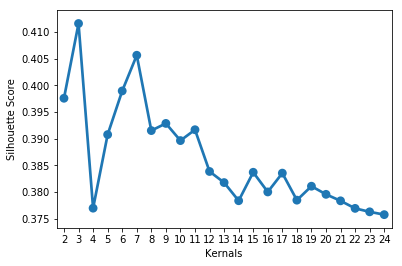

In [133]:
import matplotlib as plt
%matplotlib inline
sns.pointplot(x='Kernals', y = 'Silhouette Score', data = Kdf)

It appears that the optimal number of kernals is 3, though perhaps 7 will work better if it appears that 3 is not enough

In [134]:
km3 = KMeans(n_clusters = 3, init = 'random')
km7 = KMeans(n_clusters = 7, init = 'random')


In [135]:
tsneMatrix.head()

,x_coord,y_coord
shipwreck_burger,27.015017,46.453449
fat_uncle_tony,42.558170,31.833025
dianoia,16.950874,-32.293430
lamb_chorizo,31.650385,43.383331
organ_music,-17.115101,-14.246554


In [119]:
cluster = tsneMatrix

In [122]:
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN

cluster['cluster3kmean'] = km3.fit_predict(tsneMatrix)
cluster['cluster7kmean'] = km7.fit_predict(tsneMatrix)
cluster['clusterdbscan'] = DBSCAN(eps=1.0).fit_predict(tsneMatrix)

In [136]:
ClusteredM = tsneMatrix

In [137]:
ClusteredM.head()

,x_coord,y_coord
shipwreck_burger,27.015017,46.453449
fat_uncle_tony,42.558170,31.833025
dianoia,16.950874,-32.293430
lamb_chorizo,31.650385,43.383331
organ_music,-17.115101,-14.246554


In [138]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(affinity = 'nearest_neighbors', assign_labels = 'kmeans')

In [139]:
ClusteredM['cluster'] = sc.fit_predict(tsneMatrix)

In [140]:
ClusteredM.head()

,x_coord,y_coord,cluster
shipwreck_burger,27.015017,46.453449,3
fat_uncle_tony,42.558170,31.833025,3
dianoia,16.950874,-32.293430,2
lamb_chorizo,31.650385,43.383331,3
organ_music,-17.115101,-14.246554,6


In [141]:
np.unique(ClusteredM.cluster)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [142]:
ClusteredM.head()
t = ClusteredM.reset_index()
t.columns = ['word', 'x_coord', 'y_coord', 'cluster']

### Plotting with Bokeh

In [143]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value

output_notebook()

Loading BokehJS ...

In [661]:
# add our DataFrame as a ColumnDataSource for Bokeh
plot_data = ColumnDataSource(tsneMatrix)

# create the plot and configure the
# title, dimensions, and tools
tsne_plot = figure(title=u't-SNE Word Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   tools= (u'pan, wheel_zoom, box_zoom,'
                           u'box_select, reset'), #, resize
                   active_scroll=u'wheel_zoom')

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips = u'@word') )

# draw the words as circles on the plot
tsne_plot.circle(u'x_coord', u'y_coord', source=plot_data,
                 color=u'cluster', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# configure visual elements of the plot
tsne_plot.title.text_font_size = value(u'16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# engage!
show(tsne_plot);

E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: x_coord, y_coord [renderer: GlyphRenderer(id='10abb41a-76ae-47d7-a238-53b4ad79d7df', ...)]
E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: x_coor, y_coor [renderer: GlyphRenderer(id='224de2f8-9960-47bd-b583-fc526799ec3e', ...)]
E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: x_coor, y_coor [renderer: GlyphRenderer(id='4a14db9a-70b6-49f4-9aef-355d4636aba0', ...)]
E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: x_coor, y_coor [renderer: GlyphRenderer(id='84bed822-ce25-40fb-bad8-bffcb5b38c34', ...)]
E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: x_coor, y_coor [renderer: GlyphRenderer(id='a8200f8c-c604-42cd-981c-15e252f9424c', ...)]
E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: x_coor, y_coor [renderer: GlyphRenderer(id='bc451bf0-cb73-450f-9ce5-59dee52edcfd', ...)]
E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column n

In [591]:

ClusteredM.describe()

,x_coord,y_coord,cluster
count,5000.000000,5000.000000,5000.000000
mean,0.404878,0.934650,3.158600
std,28.093380,30.798782,1.910229
min,-62.115566,-63.852104,0.000000
25%,-20.918108,-23.172061,2.000000
50%,0.633059,-1.501964,3.000000
75%,22.649648,27.643837,5.000000
max,59.165852,62.790535,7.000000


In [147]:
ClusteredM = ClusteredM.reset_index()
ClusteredM.columns = ['words', 'x_coord', 'y_coord', 'cluster']

In [146]:
ClusteredM.head()

,x_coord,y_coord,cluster
shipwreck_burger,27.015017,46.453449,3
fat_uncle_tony,42.558170,31.833025,3
dianoia,16.950874,-32.293430,2
lamb_chorizo,31.650385,43.383331,3
organ_music,-17.115101,-14.246554,6


In [166]:
#add our DataFrame as a ColumnDataSource for Bokeh
#plot_data = ColumnDataSource(tsneMatrix)
from bokeh.resources import CDN
from bokeh.embed import file_html
from bokeh.io import output_file, show




tsne_plot = figure(title=u't-SNE Word Embeddings',
                   output_backend="webgl",
                   plot_width = 800,
                   plot_height = 800,
                   tools= (u'pan, wheel_zoom, box_zoom,'
                           u'box_select, reset'), #, resize
                   active_scroll=u'wheel_zoom')

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips = u'@words') )

# draw the words as circles on the plot
tsne_plot.circle(u'x_coord', u'y_coord', source=ColumnDataSource(ClusteredM[ClusteredM.cluster == 0]),
                 color=u'Purple', line_alpha=0.2, fill_alpha=0.1, 
                 size=10, hover_line_color=u'black')

# draw the words as circles on the plot
tsne_plot.circle(u'x_coord', u'y_coord', source=ColumnDataSource(ClusteredM[ClusteredM.cluster == 1]),#legend = u'cluster',
                 color=u'navy', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')


# draw the words as circles on the plot
tsne_plot.circle(u'x_coord', u'y_coord', source=ColumnDataSource(ClusteredM[ClusteredM.cluster == 2]),#legend = u'cluster',
                color=u'orange', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')


# draw the words as circles on the plot
tsne_plot.circle(u'x_coord', u'y_coord', source=ColumnDataSource(ClusteredM[ClusteredM.cluster == 3]),#legend = u'cluster',
                 color=u'red', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# draw the words as circles on the plot
tsne_plot.circle(u'x_coord', u'y_coord', source=ColumnDataSource(ClusteredM[ClusteredM.cluster == 4]),#legend = u'cluster',
                 color=u'blue', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')


# draw the words as circles on the plot
tsne_plot.circle(u'x_coord', u'y_coord', source=ColumnDataSource(ClusteredM[ClusteredM.cluster == 5]),#legend = u'cluster',
                 color=u'yellow', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# draw the words as circles on the plot
tsne_plot.circle(u'x_coord', u'y_coord', source=ColumnDataSource(ClusteredM[ClusteredM.cluster == 6]),#legend = u'cluster',
                 color=u'green', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# draw the words as circles on the plot
tsne_plot.circle(u'x_coord', u'y_coord', source=ColumnDataSource(ClusteredM[ClusteredM.cluster == 7]),#legend = u'cluster',
                 color=u'pink', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')


# configure visual elements of the plot
tsne_plot.title.text_font_size = value(u'16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# engage!
#show(tsne_plot);
output_file('PizzaClusteringWebGL.html')
#show(tsne_plot)

In [345]:
#add our DataFrame as a ColumnDataSource for Bokeh
#plot_data = ColumnDataSource(tsneMatrix)

# 7 Kmeans kernals

plotData20 = ColumnDataSource(tsneMatrixCluster20)
plotData21 = ColumnDataSource(tsneMatrixCluster21)
plotData22 = ColumnDataSource(tsneMatrixCluster22)
plotData23 = ColumnDataSource(tsneMatrixCluster23)
plotData24 = ColumnDataSource(tsneMatrixCluster24)
plotData25 = ColumnDataSource(tsneMatrixCluster25)
plotData26 = ColumnDataSource(tsneMatrixCluster26)

#colorList = ['#d18096', '#483496', '#00FFD0']
#labels = tsneMatrix['cluster'].astype(int)
#colors = colorList[labels]
# create the plot and configure the
# title, dimensions, and tools
tsne_plot = figure(title=u't-SNE Word Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   tools= (u'pan, wheel_zoom, box_zoom,'
                           u'box_select, reset'), #, resize
                   active_scroll=u'wheel_zoom')

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips = u'@word') )

# draw the words as circles on the plot
tsne_plot.circle(u'x_coor', u'y_coor', source=plotData20,
                 color=u'Purple', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# draw the words as circles on the plot
tsne_plot.circle(u'x_coor', u'y_coor', source=plotData21,
                 color=u'navy', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')


# draw the words as circles on the plot
tsne_plot.circle(u'x_coor', u'y_coor', source=plotData22,
                 color=u'orange', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')


# draw the words as circles on the plot
tsne_plot.circle(u'x_coor', u'y_coor', source=plotData23,
                 color=u'red', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# draw the words as circles on the plot
tsne_plot.circle(u'x_coor', u'y_coor', source=plotData24,
                 color=u'green', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')


# draw the words as circles on the plot
tsne_plot.circle(u'x_coor', u'y_coor', source=plotData25,
                 color=u'yellow', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# draw the words as circles on the plot
tsne_plot.circle(u'x_coor', u'y_coor', source=plotData26,
                 color=u'pink', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')




# configure visual elements of the plot
tsne_plot.title.text_font_size = value(u'16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# engage!
show(tsne_plot);

In [343]:
#add our DataFrame as a ColumnDataSource for Bokeh
#plot_data = ColumnDataSource(tsneMatrix)
# 3 Kmeans kernals

plotData0 = ColumnDataSource(tsneMatrixCluster0)
plotData1 = ColumnDataSource(tsneMatrixCluster1)
plotData2 = ColumnDataSource(tsneMatrixCluster2)

#colorList = ['#d18096', '#483496', '#00FFD0']
#labels = tsneMatrix['cluster'].astype(int)
#colors = colorList[labels]
# create the plot and configure the
# title, dimensions, and tools
tsne_plot = figure(title=u't-SNE Word Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   tools= (u'pan, wheel_zoom, box_zoom,'
                           u'box_select, reset'), #, resize
                   active_scroll=u'wheel_zoom')

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips = u'@word') )

# draw the words as circles on the plot
tsne_plot.circle(u'x_coor', u'y_coor', source=plotData0,
                 color=u'Purple', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# draw the words as circles on the plot
tsne_plot.circle(u'x_coor', u'y_coor', source=plotData1,
                 color=u'navy', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')


# draw the words as circles on the plot
tsne_plot.circle(u'x_coor', u'y_coor', source=plotData2,
                 color=u'orange', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')





# configure visual elements of the plot
tsne_plot.title.text_font_size = value(u'16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# engage!
show(tsne_plot);